<p><img alt="Colaboratory logo" height="65px" src="https://upload.wikimedia.org/wikipedia/en/thumb/b/b1/Davivienda_logo.svg/1200px-Davivienda_logo.svg.png" align="left" hspace="10px" width="20%" vspace="15px"></p>

<h1 align="center"> Prueba Técnica Profesional III Departamento de Datos no Estructurados  </h1>
 <h2 align = "center"> Autor: Andres Ochoa Arango </h2> 


#### **Objetivo**
El objetivo de este reto es lograr un filtro que discrimine automáticamente un tipo de documento sin información relevante: páginas en blanco. Se busca que este filtro reciba como entrada una carpeta con imágenes de documentos diversos y produzca como salida dos carpetas, una con imágenes de páginas sin contenido y otra con imágenes de páginas con contenido.


In [3]:
#Librerias implementadas
import os
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
try:
    import cv2
except:
    !pip install cv2
try:
    import seaborn as sns
except:
    !pip install seaborn
try:
    import tensorflow as tf
except:
    !pip install tensorflow

try: 
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score, recall_score, f1_score
except: 
    !pip install sklearn

try: 
    import warnings
    warnings.filterwarnings("ignore")
except: 
    !pip install warnings

## Clasificación de Imágenes

### 1.Importe las imágenes

In [4]:
#Lector de la informacion en formato .png
DIR = './Datasets' 
dirname = os.path.join(os.getcwd(), DIR)
imgpath = dirname + os.sep 


images = []
directories = []
dircount = []
prevRoot=''
cant=0
img_size = 600 #Cantidad de pixeles utilizados el resize de los datos 
#Realizar una trasformación de las imagenes para normalizar la información.
#Para normalizar, le cambiamos el tamaño a la hora de importar la información 
print("leyendo imagenes de ",imgpath)
for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            #Se utiliza la libereia cv2 para realizar la lectura de la información
            image = cv2.imread(filepath , cv2.IMREAD_GRAYSCALE) 
            image_re = cv2.resize(image, (img_size, img_size)) #Cambiando el tamaño de las imaganes
            images.append(image_re)
            b = "\t\tImagen...\t\t" + str(cant)
            
            print (b, end="\r")
            #En esta parte se realiza un condicional para pasar por todas las carpertas
            #que puedan tener informacion dentro de './Datasets'
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)
dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  C:\Users\Administrador\./Datasets\
C:\Users\Administrador\./Datasets\Blanco 1
C:\Users\Administrador\./Datasets\Documentos 147
Directorios leidos: 2
Imagenes en cada directorio [148, 99]
suma Total de imagenes en subdirs: 247


In [5]:
#Ahora de manera adicional, se obtiene el nombre de las carpetas
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))
 
docs =[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    docs.append(name[len(name)-1])
    indice=indice+1
 
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
 

classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Cantidad etiquetas creadas:  247
0 Blanco
1 Documentos
Total number of outputs :  2
Output classes :  [0 1]


### 2. Estructure la información
Para realizar la estructura de la información a utilizar, se va a proceder a separar los datos en entrenamiento y control. La cantidad de datos que se usaran para el control seran del 66\% de la muestra y lo de testeo son el 33\% de la misma. Para normalizar datos y poder obtener mejor resultados a la hora del entrenamiento, se dividen los datos por 255. Con la finalidad, de tener valores entre 1-0. 

Adicionalmente, se debe realizar una trasformacion para los targets o las ys. En este caso, se realiza un one-hot-encoding. Este paso se justifica, bajo los requerimientos solicitados por el algoritmo.

In [8]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.33)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
# Proceso de normalización
train_X = train_X / 255.
test_X = test_X / 255.

# En estos codigos se realiza la transformación por one-hot-encoding
# Se utiliza el algoritmo de la libreria tensorflow para buscar mayor compatibilidad
train_Y_one_hot = tf.keras.utils.to_categorical(train_Y)
test_Y_one_hot = tf.keras.utils.to_categorical(test_Y)

print('Label original:', train_Y[0])
print('Luego de la conversion del one-hot-encoding:', train_Y_one_hot[0])

# Buscando compatibilidad con el modelo, se cambia las dimensiones de las Xs
train_X = train_X.reshape(train_X.shape[0], img_size, img_size, 1)

print(train_X.shape)

Training data shape :  (165, 600, 600) (165,)
Testing data shape :  (82, 600, 600) (82,)
Label original: 0
Luego de la conversion del one-hot-encoding: [1. 0.]
(165, 600, 600, 1)


### 3. Describa su Estrategia de Análisis

Para este caso, se realizó un modelo de Deep Learning. Concretamente, una red neuronal convolucional. La primera capa es de 32 núcleos con una matriz (3,3). Esto con la finalidad de abstraer patrones relvantes de los datos y poder obtener resultados generalizables. Luego, se realizo un proceso de Droupout buscando evitar la inutilización de algunas neuronas. Y para terminar, se agrego una capa densa de 50 neuronas con una funcion de activacion relu. 

La justificacion de este modelo, es la busqueda de unos resultados que sean eficientes a nivel computacional. Para el caso de las funciones de activación, se presentan en algunos [papers](https://arxiv.org/pdf/1710.05941v2.pdf) como la funcion de activacion mas eficientes.  Por otro lado, por la cantidad limitada de datos me llevó a optar por un modelo sencillo que pueda dar buenos resultados en la etapa de testeo.

*Nota:* Si la siguiente celda de ejecuta de nuevo, existe la posibilidad de obtener resultados diferentes a los de la presentación

In [9]:

epochs = 6
batch_size = 5


modelo2 =  tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation="softmax")
])


#Compilación
optimizer = tf.keras.optimizers.Adam(lr=0.01)
modelo2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# Fase de entrenamiento del modelo
historia_modelo = modelo2.fit(train_X, train_Y_one_hot, batch_size=batch_size,epochs=epochs,verbose=1, validation_split=0.33)

Epoch 1/6
22/22 [==============================] - 37s 2s/step - loss: 142.3972 - accuracy: 0.5909 - val_loss: 0.8705 - val_accuracy: 0.5091
Epoch 2/6
22/22 [==============================] - 33s 1s/step - loss: 1.4030 - accuracy: 0.7545 - val_loss: 0.7123 - val_accuracy: 0.6727
Epoch 3/6
22/22 [==============================] - 31s 1s/step - loss: 0.3725 - accuracy: 0.9364 - val_loss: 0.3214 - val_accuracy: 0.9455
Epoch 4/6
22/22 [==============================] - 32s 1s/step - loss: 0.2491 - accuracy: 0.9636 - val_loss: 0.2226 - val_accuracy: 0.9455
Epoch 5/6
22/22 [==============================] - 32s 1s/step - loss: 0.1817 - accuracy: 0.9636 - val_loss: 0.1635 - val_accuracy: 0.9636
Epoch 6/6
22/22 [==============================] - 33s 1s/step - loss: 0.1286 - accuracy: 0.9818 - val_loss: 0.1302 - val_accuracy: 0.9636


In [11]:
#En esta parte se muestra el detalle del modelo
modelo2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 598, 598, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 299, 299, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 299, 299, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 2860832)           0         
_________________________________________________________________
dense (Dense)                (None, 50)                143041650 
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 143,042,072
Trainable params: 143,042,072
Non-trainable params: 0
__________________________________________

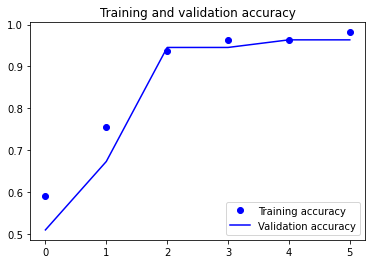

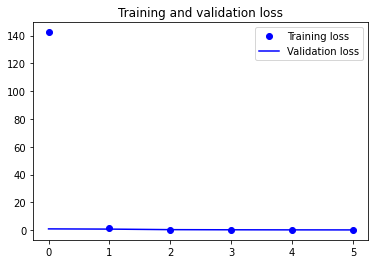

In [12]:
# Graficacion de la linea de aprendizaje del modelo
accuracy = historia_modelo.history['accuracy']
val_accuracy = historia_modelo.history['val_accuracy']
loss = historia_modelo.history['loss']
val_loss = historia_modelo.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [13]:
# Predicción de los resultados de testo. 
# Se realizan diferentes trasnformaciónes
test_X = test_X.reshape(test_X.shape[0], img_size, img_size, 1)

test_eval = modelo2.evaluate(test_X, test_Y_one_hot, verbose=0)
 
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

y_predict = modelo2.predict(test_X)
y_predict_2 = pd.get_dummies(pd.DataFrame(np.round(y_predict))).idxmax(1)

Test loss: 0.21090064942836761
Test accuracy: 0.9268292784690857


### 4. Interpretación de Reusultados
En esta celda se encuentras las diferentes metricas de evaluación para un modelo de clasificación. Según los labels, (0 Sin contenido y 1 con contendio) se obtuvo un resultado en el ejercicio que se puede mejorar con la implementación de metodos para aumentar la muestra con las datos que se tienen.

La interpretacion de las metricas dependen de los errores que se deseen minimizar. Para el caso de los docuementos, lo que se desea minimizar es la perdida de informacion por la mala caracterizacion de los docuementos con información. Por ende, la evaluacion *Recall* es la que se desearia minizar. Para este caso presenta una evaluacion del 84\%, lo cual es una medida que debe ser escogida bajo un justificación pertinente. 


      Separacion->
      Accuracy: 0.926829268292683
      Precision: 0.9655172413793104
      Recall: 0.8484848484848485
      F1: 0.9032258064516129
      


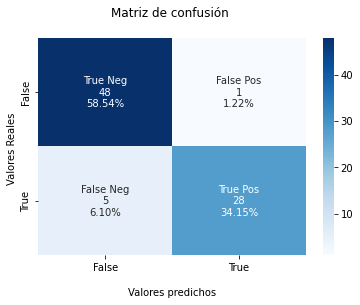

In [14]:
confusion = confusion_matrix(test_Y, y_predict_2)
acu= accuracy_score(test_Y, y_predict_2)
prec = precision_score(test_Y, y_predict_2)
re = recall_score(test_Y, y_predict_2)
f1 = f1_score(test_Y, y_predict_2)
print('''En este caso los valores verdadereos (1) hacen referencia a las documentos con información y 
los datos falsos (0) hacen refencia a los documentos sin información.''')
print('''
      Separacion->
      Accuracy: {}
      Precision: {}
      Recall: {}
      F1: {}
      '''.format(acu,prec,re, f1))
      
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                confusion.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     confusion.flatten()/np.sum(confusion)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(confusion, annot=labels, fmt='', cmap='Blues')

ax.set_title('Matriz de confusión \n ');
ax.set_xlabel('\nValores predichos')
ax.set_ylabel('Valores Reales ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()